In [4]:
# coding=utf-8
import math
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import joblib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, plot_confusion_matrix
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, mean_squared_error, \
    r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, f_regression, \
    mutual_info_regression, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from xgboost import XGBClassifier, XGBRegressor
from sklearn import model_selection
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, validation_curve, \
    StratifiedGroupKFold
from sklearn.ensemble import IsolationForest
import warnings

# %matplotlib
# %matplotlib inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)


class RedWine:
    def __init__(self, model=LogisticRegression(), params=(8, 1, 1, 10)):
        self.model = model
        (self.tr, self.v, self.tt, self.g) = params
        self.fold = int(1 / (self.v / (self.tr + self.v)))
        self.df = pd.read_csv('./winequality-red.csv')
        self.c_label = 'quality'
        self.dfx = self.df.drop(self.c_label, axis=1)  # original X
        self.dfy = self.df[[self.c_label]]
        self.dfy[self.c_label] = MinMaxScaler().fit(self.dfy).transform(self.dfy).flatten()
        self.dfy = self.dfy[self.c_label]
        self.rp = None
        self.cm = None
        self.mae = None
        self.r2 = None
        self.mse = None
        self.ac = None
        self.y_pred = None
        self.gs = None
        self.y_valid = None
        self.y_train = None
        self.X_valid = None
        self.X_train = None
        self.y_test = None
        self.y_modeling = None
        self.X_test = None
        self.X_modeling = None

    def eda_check_nan(self):
        """
        step 1: Check for missing values and handle if any
        :return:
        """
        is_there_any_null_values = self.df.isnull().values.any()
        print("[EDA] is there any null values: ", is_there_any_null_values)
        plt.figure(figsize=(15, 6))
        sns.heatmap(self.df.isnull(), cmap="viridis")

    def eda_outliers(self):
        """
        step 2: Check for outliers if any and handle them
        :return:
        """

    def eda_feature_correlations_heatmap(self):
        """
        step 3: Implement Correlation heatmap
        :return:
        """
        plt.figure(figsize=(10, 10))
        sns.heatmap(self.dfx.corr(), annot=True, linewidths=.5, fmt='.1f', cmap="viridis")
        plt.title("feature correlation heatmap")

    def eda_feature_distribution_visualization(self, col_idx):
        c = self.dfx.columns[col_idx]
        f = self.dfx[[c]]
        self.dist_plot(f, c)
        return

    @staticmethod
    def dist_plot(f, c, color="brown"):
        plt.figure(figsize=(16, 4))
        sns.distplot(f, kde=True, color=color)
        plt.title("\"%s\" (%.2f, %.2f)" % (c, f.min(), f.max()))
        plt.show()
        pass

    def eda_feature_log_scaling(self, col_idx, color="r", plot=False):
        c = self.dfx.columns[col_idx]
        f = self.dfx[[c]]
        tmp = np.log(f + 1)
        if plot:
            self.dist_plot(tmp, c, color)
        self.dfx[[c]] = tmp
        pass

    def eda_feature_standard(self, col_idx, color="b", plot=False):
        c = self.dfx.columns[col_idx]
        f = self.dfx[[c]]
        tmp = StandardScaler().fit(f).transform(f)
        if plot:
            self.dist_plot(tmp, c, color)
        self.dfx[[c]] = tmp
        pass

    def eda_feature_minmax(self, col_idx, color="g", plot=False):
        c = self.dfx.columns[col_idx]
        f = self.dfx[[c]]
        tmp = MinMaxScaler().fit(f).transform(f)
        if plot:
                self.dist_plot(tmp, c, color)
        self.dfx[[c]] = tmp
        pass

    def eda_dfx_scaling(self, plot=False):
        if plot:
            sns.pairplot(self.dfx, kind="kde")
        i = 0
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 1
        self.eda_feature_minmax(i, plot=plot)
        i = 2
        self.eda_feature_minmax(i, plot=plot)
        i = 3
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 4
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 5
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 6
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 7
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 8
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 9
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        i = 10
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_log_scaling(i, plot=plot)
        self.eda_feature_minmax(i, plot=plot)
        #
        if plot:
            sns.pairplot(self.dfx, kind="kde")
        pass

    def eda_info(self):
        print(self.df.info())
        return

    def eda_describe(self):
        summary = pd.DataFrame(self.df.describe().T)
        summary = summary.style.background_gradient(cmap='Reds') \
            .set_table_attributes("style = 'display: inline'") \
            .set_caption('Statistics of the Dataset') \
            .set_table_styles([{
            'selector': 'caption',
            'props': [
                ('font-size', '16px')
            ]
        }])
        return summary

    def outlier_removal(self, debug_log=False):
        def plot_outliers_1(iso_df, title):
            c3 = iso_df.columns[3]
            c4 = iso_df.columns[4]
            r31 = iso_df[iso_df['result'] == 1][[c3, c4]]
            r32 = iso_df[iso_df['result'] == -1][[c3, c4]]

            fig, ax = plt.subplots()
            ax.scatter(r31[c3], r31[c4], marker="o")
            ax.scatter(r32[c3], r32[c4], marker="x", color='r', linewidth=0.5)
            plt.title(title)
            plt.show()

        def plot_outliers_2(iso_df, title):
            c3 = iso_df.columns[3]
            c4 = iso_df.columns[4]
            r31 = iso_df[iso_df['tmp'] == 'remained_sample'][[c3, c4]]
            r32 = iso_df[iso_df['tmp'] == 'to_be_removed_sample'][[c3, c4]]
            r33 = iso_df[iso_df['tmp'] == 'novelty_sample'][[c3, c4]]

            fig, ax = plt.subplots()
            ax.scatter(r31[c3], r31[c4], marker="o")
            ax.scatter(r32[c3], r32[c4], marker="x", color='r', linewidth=0.5)
            ax.scatter(r33[c3], r33[c4], marker="*", color='orange')
            plt.title(title)
            plt.show()

        def scorer_f(estimator, X):
            return np.mean(estimator.score_samples(X))

        # # model.best_params_ :  {'bootstrap': False, 'contamination': 0.015, 'max_samples': 0.9, 'n_estimators': 50, 'n_jobs': 1, 'verbose': 1}
        # # tuned = {
        # # #          'n_estimators':[50,80,100,120,150,200,250,300],
        # #          'n_estimators':[200],
        # # #          'max_samples':['auto', 0.1,0.5,0.9,0.99],
        # #          'max_samples':[0.99],
        # # #          'contamination':['legacy', 'outo'],
        # #          'contamination':[0.015],
        # # #          'max_features':[1,2,3,4,5,6,7,8,9,10,11,12,13],
        # #          'max_features':[11],
        # # #          'bootstrap':[True,False],
        # #          'bootstrap':[False],
        # # #          'n_jobs':[None,1,2,3,4,5,6,7,8,10,15,20,25,30],
        # #          'n_jobs':[25],
        # # #          'verbose':[0,1,2,3,4,5,6,7,8,9,10],
        # #          'verbose':[5],
        # # #          'warm_start':[True,False],
        # #          'warm_start':[False],
        # #         }

        # isolation_forest = GridSearchCV(IsolationForest(), tuned, scoring=scorer_f)
        # best_model = isolation_forest.fit(dfx_scaling)
        # arr = best_model.predict(dfx_scaling)
        # print("model.best_params_ : ", best_model.best_params_)
        # print("scorer_f : ", scorer_f(clf, dfx_scaling))
        # arr = best_model.predict(dfx_scaling)

        # find outliers
        r = random.randint(1, 10000)
        if debug_log:
            print("random_state=%d" % r)
        clf = IsolationForest(random_state=8854, max_samples=0.99, bootstrap=False, n_estimators=50, n_jobs=50)
        clf.fit(self.dfx)
        iforest_arr = clf.predict(self.dfx)
        dfx_if = self.dfx.copy(deep=True)
        dfx_if['result'] = iforest_arr

        dfx_recall = dfx_if
        if debug_log:
            print("sample size of label:\n%s\n" % pd.value_counts(self.dfy.to_numpy().flatten()))
        idx_outliers = dfx_recall[dfx_recall['result'] == -1].index
        if debug_log:
            print("sample size of outliers of label:\n%s\n" % pd.value_counts(self.dfy[idx_outliers]))
        dfx_recall[self.c_label] = self.dfy
        dfx_recall[(dfx_recall['result'] == -1) &
                   (dfx_recall[self.c_label] != 0)
                   ]['to_be_removed'] = 1
        idx_outliers = dfx_recall[(dfx_recall['result'] == -1) &
                                  (dfx_recall[self.c_label] != 0) &
                                  (dfx_recall[self.c_label] != 5)
                                  ].index
        if debug_log:
            print(
                "sample size of outliers of label, refuse category 0:\n%s\n" % pd.value_counts(self.dfy[idx_outliers]))
        dfx_recall['tmp'] = 'remained_sample'
        dfx_recall.loc[(dfx_recall['result'] == -1) &
                       (dfx_recall[self.c_label] != 0) & (
                               dfx_recall[self.c_label] != 5), 'tmp'] = 'to_be_removed_sample'
        dfx_recall.loc[(dfx_recall['result'] == -1) &
                       ((dfx_recall[self.c_label] == 0) | (dfx_recall[self.c_label] == 5)), 'tmp'] = 'novelty_sample'
        if debug_log:
            print("sample size of outliers to be removed:\n%s\n" % pd.value_counts(dfx_recall['tmp']))
        # remove final outliers
        df_rm_outliers = dfx_recall.drop(dfx_recall[dfx_recall['tmp'] == 'to_be_removed_sample'].index, axis=0)
        dfx_rmo = df_rm_outliers.drop(['result', 'quality', 'tmp'], axis=1)
        dfy_rmo = df_rm_outliers['quality']

        if debug_log:
            # plots
            f = scorer_f(clf, self.dfx)
            print("\nscorer_f : %.6f, rand_seed: %d" % (f, r))
            plot_outliers_1(dfx_if, 'iforest outliers')
            plot_outliers_2(dfx_recall, 'iforest outliers(rare label samples[RED])')
            plot_outliers_2(df_rm_outliers, 'iforest outliers(rare label samples remained')

            print(dfx_if[dfx_if.columns[3]].max(), dfx_if[dfx_if.columns[4]].max())
            print(dfx_recall[dfx_recall.columns[3]].max(), dfx_recall[dfx_recall.columns[4]].max())
            print(df_rm_outliers[df_rm_outliers.columns[3]].max(), df_rm_outliers[df_rm_outliers.columns[4]].max())
        self.dfx, self.dfy = dfx_rmo, dfy_rmo
        pass

    def feature_importance(self):
        clf = XGBRegressor()
        clf.fit(self.dfx, self.dfy)
        feat_importance = pd.DataFrame(clf.feature_importances_, index=self.dfx.columns, columns=["Importance"])
        feat_importance.sort_values(by='Importance', ascending=False, inplace=True)
        feat_importance.plot(kind='bar')
        return

    @staticmethod
    def print_title():
        print("%15s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s" %
              ("model", "mean", "std", "accuracy", "precision", "recall", "latency"))

    @staticmethod
    def print_result(tup):
        name, model, r = tup
        print("%15s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s" %
              ("%s" % name, "%.3f" % r[0], "", "%.3f" % r[2], "%.3f" % r[3], "%.3f" % r[4], "%.3f ms" % r[5]))

    @staticmethod
    # see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    def __plot_cv_indices(cv, x, y, group, ax, n_splits, lw=10):
        """Create a sample plot for indices of a cross-validation object."""

        ii = 0
        # Generate the training/testing visualizations for each CV split
        for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
            # Fill in indices with the training/src groups
            indices = np.array([np.nan] * len(x))
            indices[tt] = 1
            indices[tr] = 0

            # Visualize the results
            ax.scatter(
                range(len(indices)),
                [ii + 0.5] * len(indices),
                c=indices,
                marker="_",
                lw=lw,
                cmap=plt.cm.coolwarm,
                vmin=-0.2,
                vmax=1.2,
            )

        # Plot the data classes and groups at the end
        ax.scatter(range(len(x)), [ii + 1.5] * len(x), c=y, marker="_", lw=lw, cmap=plt.cm.Paired)
        ax.scatter(range(len(x)), [ii + 2.5] * len(x), c=group, marker="_", lw=lw, cmap=plt.cm.Paired)

        # Formatting
        yticklabels = list(range(n_splits)) + ["iris spices", "random group"]
        ax.set(
            yticks=np.arange(n_splits + 2) + 0.5,
            yticklabels=yticklabels,
            xlabel="Sample index",
            ylabel="CV iteration",
            ylim=[n_splits + 2.2, -0.2],
            xlim=[0, group.shape[0]],
        )
        ax.set_title("{} : {}".format(type(cv).__name__, "training will sequentially access each shuffled group"),
                     fontsize=15)
        return ax

    def plot_learning_curve(self, cross_val):
        print(metrics.get_scorer_names())
        # ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy',
        # 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted',
        # 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples',
        # 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss',
        # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance',
        # 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error',
        # 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision',
        # 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score',
        # 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo',
        # 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']
        # Backend MacOSX is interactive backend. Turning interactive mode on.
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
            self.gs,
            self.X_train,
            self.y_train,
            scoring='accuracy',
            cv=cross_val,
            return_times=True,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)
        # Plot learning curve
        axes = None
        title = 'learning curve'
        ylim = None
        if axes is None:
            _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].set_title(title)
        if ylim is not None:
            axes[0].set_ylim(*ylim)
        axes[0].set_xlabel("Training examples")
        axes[0].set_ylabel("Score")
        axes[0].grid()
        axes[0].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )
        axes[0].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
        axes[0].plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        axes[0].plot(
            train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
        )
        axes[0].legend(loc="best")
        # Plot n_samples vs fit_times
        axes[1].grid()
        axes[1].plot(train_sizes, fit_times_mean, "o-")
        axes[1].fill_between(
            train_sizes,
            fit_times_mean - fit_times_std,
            fit_times_mean + fit_times_std,
            alpha=0.1,
        )
        axes[1].set_xlabel("Training examples")
        axes[1].set_ylabel("fit_times")
        axes[1].set_title("Scalability of the model")
        # Plot fit_time vs score
        fit_time_argsort = fit_times_mean.argsort()
        fit_time_sorted = fit_times_mean[fit_time_argsort]
        test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
        test_scores_std_sorted = test_scores_std[fit_time_argsort]
        axes[2].grid()
        axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
        axes[2].fill_between(
            fit_time_sorted,
            test_scores_mean_sorted - test_scores_std_sorted,
            test_scores_mean_sorted + test_scores_std_sorted,
            alpha=0.1,
        )
        axes[2].set_xlabel("fit_times")
        axes[2].set_ylabel("Score")
        axes[2].set_title("Performance of the model")
        plt.show()

    @staticmethod
    def dic_2_arr(d):
        return np.array(list(d.values()))

    def GridSearchCV_evaluating_visualization(self, scoring):

        results = self.gs.cv_results_  # col_ranking_metric = "mean_train_%s"%ranking_metric
        df = pd.DataFrame(self.gs.cv_results_).sort_values("mean_train_Accuracy", axis=0, ascending=True).reset_index(
            drop=True)
        results = {}
        for _, x in enumerate(df.columns):
            results[x] = df[x].values

        plt.figure(figsize=(12, 5))
        plt.title("SearchCV evaluating using multiple scorers simultaneously", fontsize=16)

        plt.xlabel("min_samples_split")
        plt.ylabel("Score")

        ax = plt.gca()
        # ax.set_xlim(0, 402)
        # ax.set_ylim(0.73, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(df.index)  # np.array(results["param_%s" % ranking_metric].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ["r", "g", "b", "k"]):
            for sample, style in (("train", "--"), ("test", "-")):
                sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
                sample_score_std = results["std_%s_%s" % (sample, scorer)]
                ax.fill_between(
                    X_axis,
                    sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == "test" else 0,
                    color=color,
                )
                ax.plot(
                    X_axis,
                    sample_score_mean,
                    style,
                    color=color,
                    alpha=1 if sample == "test" else 0.7,
                    label="%s (%s)" % (scorer, sample),
                )

            best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
            best_score = results["mean_test_%s" % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot(
                [
                    X_axis[best_index],
                ]
                * 2,
                [0, best_score],
                linestyle="-.",
                color=color,
                marker="x",
                markeredgewidth=3,
                ms=8,
            )

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

        plt.legend(loc="best")
        plt.grid(False)
        plt.show()

    def fit(self, params, scoring, rf=r2_score, search_cv=model_selection.RandomizedSearchCV, cv=None, vb=0):
        self.X_modeling, self.X_test, self.y_modeling, self.y_test = \
            train_test_split(self.dfx, self.dfy, test_size=self.tt / self.g, random_state=999, stratify=self.dfy)
        if cv is None:
            cross_val = self.fold
        else:
            if cv == 'StratifiedKFold':
                cross_val = StratifiedKFold(n_splits=self.fold)
            else:
                cross_val = cv
        self.gs = search_cv(self.model, params, cv=cross_val, verbose=vb,
                            scoring=scoring, refit=rf, return_train_score=True, )
        self.gs.fit(self.X_modeling, self.y_modeling)
        pass

    def pred(self):
        self.y_pred = self.gs.predict(self.X_test)
        self.ac = accuracy_score(self.y_test, self.y_pred)
        self.mse = mean_squared_error(self.y_test, self.y_pred)
        self.r2 = r2_score(self.y_test, self.y_pred)
        self.mae = mean_absolute_error(self.y_test, self.y_pred)
        self.cm = confusion_matrix(self.y_test, self.y_pred)
        self.rp = classification_report(self.y_test, self.y_pred)

    def plot_confusion_mat(self):
        plot_confusion_matrix(self.gs, self.X_test, self.y_test)

    def report(self):
        print(classification_report(self.y_test, self.y_pred))


if __name__ == '__main__':
    foo = RedWine(LogisticRegression())


In [6]:
foo = RedWine()
print("Categorical Variable: QUALITY")
print(foo.df[foo.c_label])
print("\n\nContinuous Variable: QUALITY")
print(foo.dfy)

Categorical Variable: QUALITY
0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64


Continuous Variable: QUALITY
0       0.4
1       0.4
2       0.4
3       0.6
4       0.4
       ... 
1594    0.4
1595    0.6
1596    0.6
1597    0.4
1598    0.6
Name: quality, Length: 1599, dtype: float64


In [7]:
foo.df.shape

(1599, 12)

In [8]:
foo.eda_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [9]:
foo.df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
foo.df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [11]:
foo.eda_describe()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.000000,8.319637,1.741096,4.600000,7.100000,7.900000,9.200000,15.900000
volatile acidity,1599.000000,0.527821,0.179060,0.120000,0.390000,0.520000,0.640000,1.580000
citric acid,1599.000000,0.270976,0.194801,0.000000,0.090000,0.260000,0.420000,1.000000
residual sugar,1599.000000,2.538806,1.409928,0.900000,1.900000,2.200000,2.600000,15.500000
chlorides,1599.000000,0.087467,0.047065,0.012000,0.070000,0.079000,0.090000,0.611000
free sulfur dioxide,1599.000000,15.874922,10.460157,1.000000,7.000000,14.000000,21.000000,72.000000
total sulfur dioxide,1599.000000,46.467792,32.895324,6.000000,22.000000,38.000000,62.000000,289.000000
density,1599.000000,0.996747,0.001887,0.990070,0.995600,0.996750,0.997835,1.003690
pH,1599.000000,3.311113,0.154386,2.740000,3.210000,3.310000,3.400000,4.010000
sulphates,1599.000000,0.658149,0.169507,0.330000,0.550000,0.620000,0.730000,2.000000


[EDA] is there any null values:  False


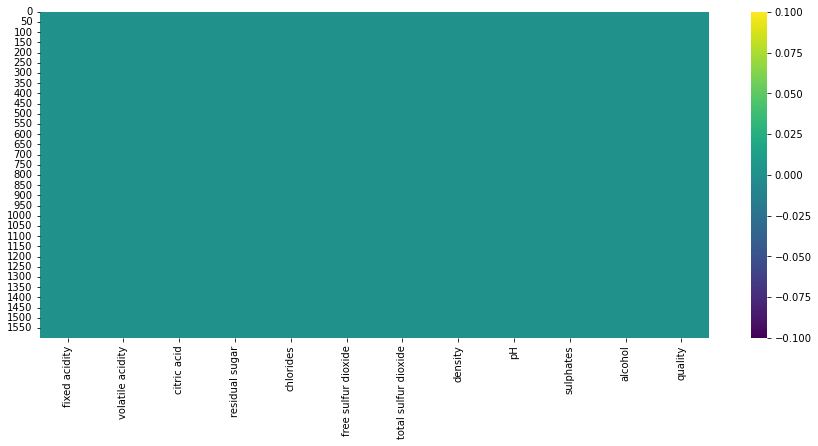

In [12]:
foo.eda_check_nan()

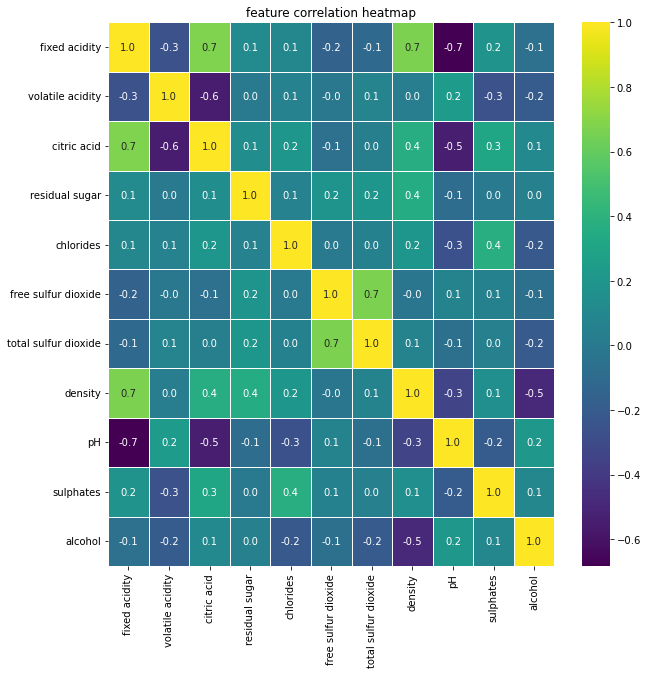

In [13]:
foo.eda_feature_correlations_heatmap()

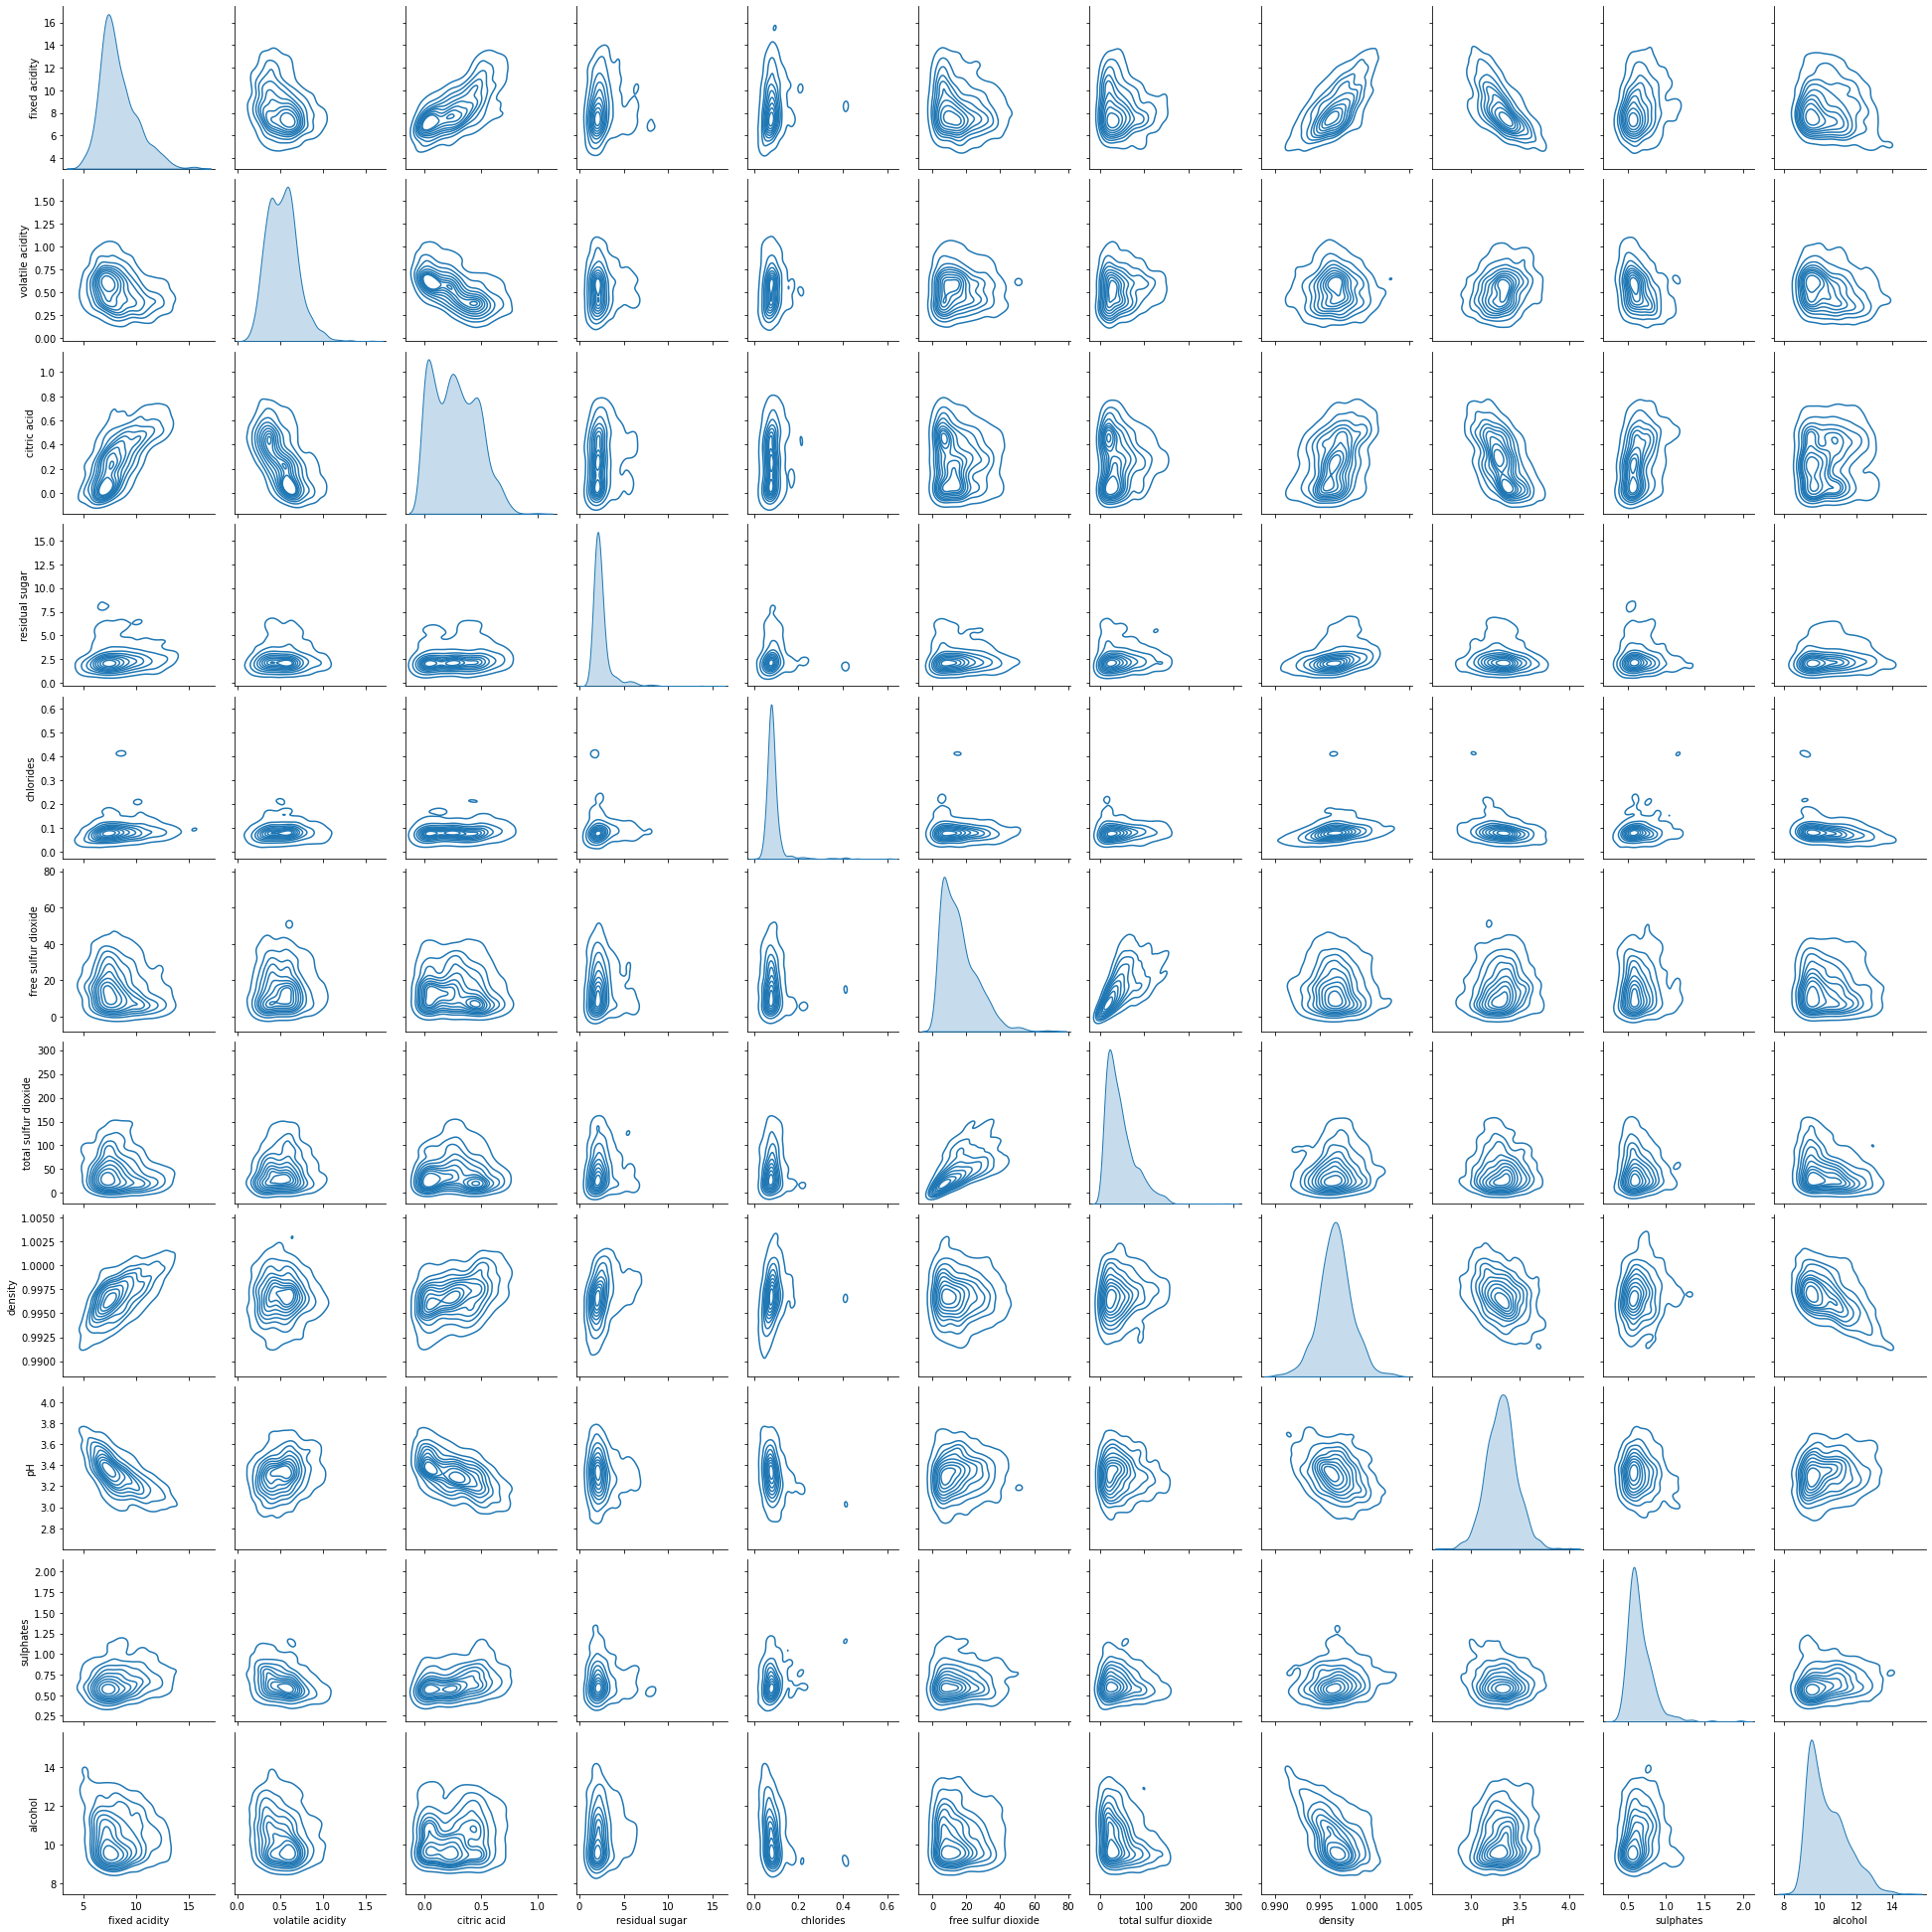

In [15]:
foo = RedWine()
sns.pairplot(foo.dfx, kind="kde")

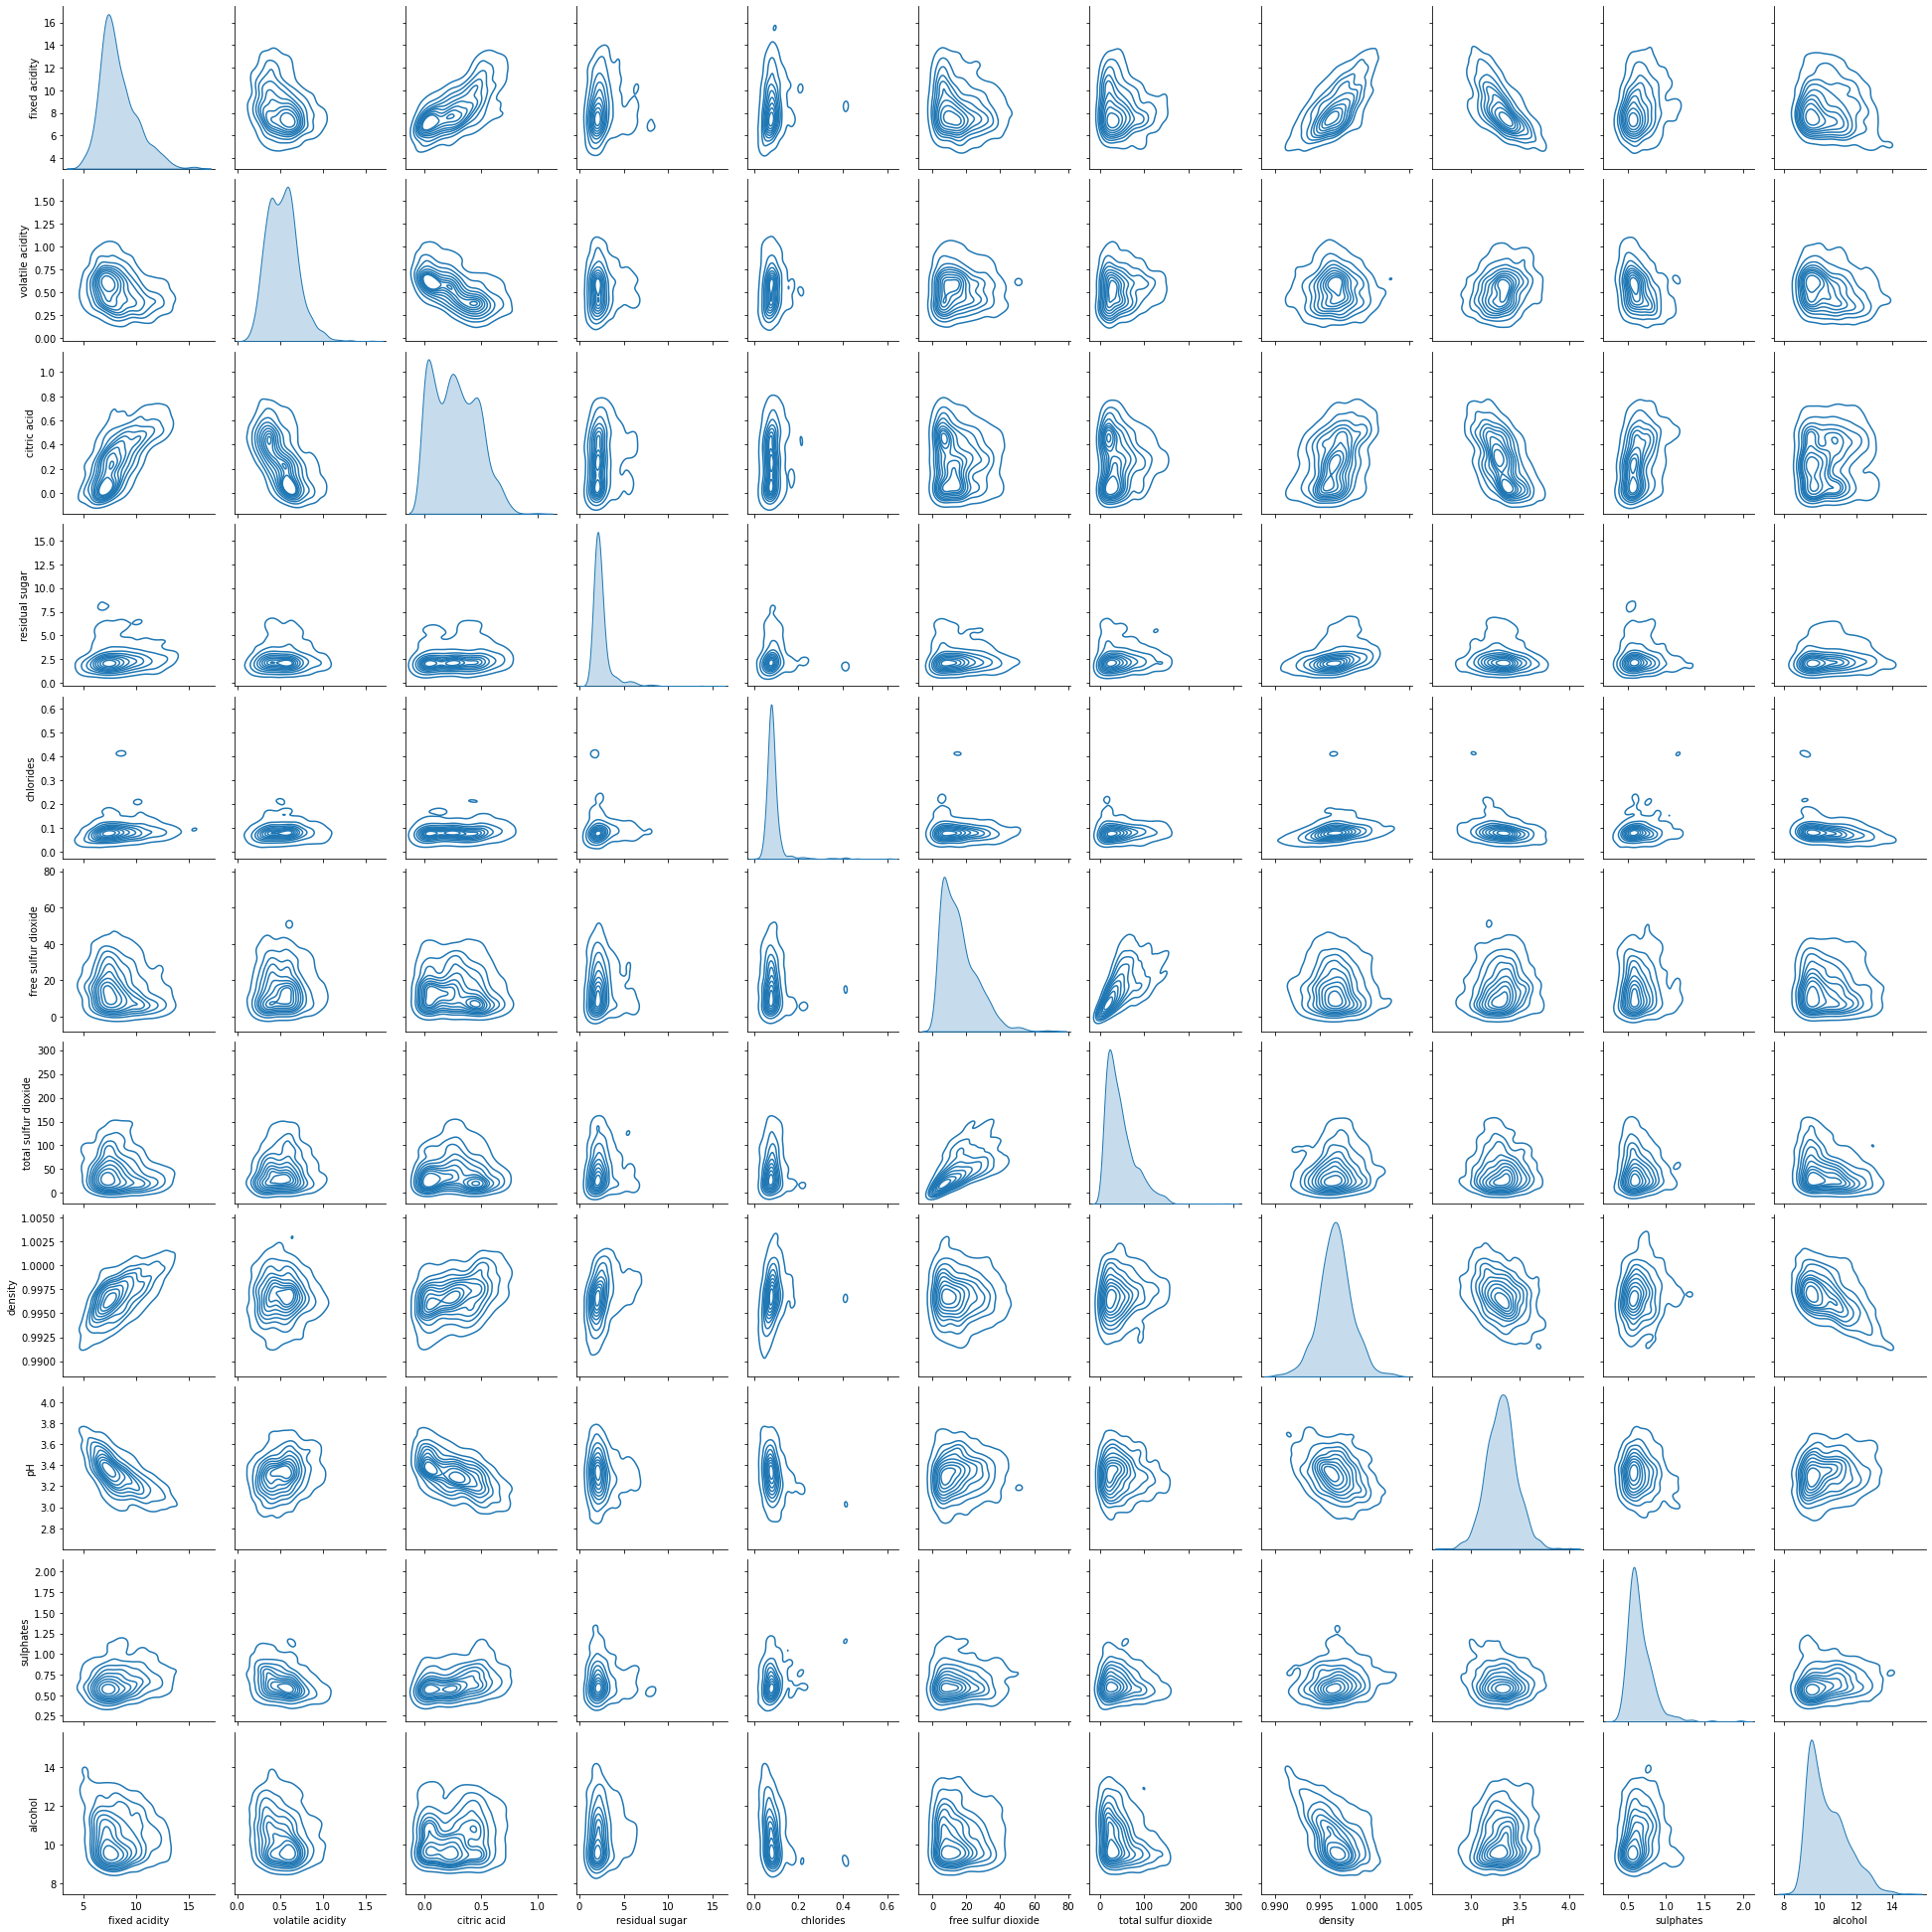

In [16]:
sns.pairplot(foo.dfx, kind="kde")